In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import copy
from sklearn.metrics import r2_score

In [2]:
# !pip install wandb

In [3]:
# import wandb

# wandb.login()

In [4]:
x = np.loadtxt('input.txt', delimiter= ' ')
#drop inert gases
x = x[:,:6]#np.delete(x, [8,9], 1)
x.shape

(500, 6)

In [5]:
y = np.loadtxt('Out_files/out0.txt', delimiter= ';')
#drop times and inert gases & consider only first 100 timesteps
y = y[:100,2:-4]
y[0]

OSError: Out_files/out0.txt not found.

In [799]:
len(x)

196

## Data Preprocessing:
Making a custom torch dataloader

In [945]:
class OxidationDataset(Dataset):

    def __init__(self, inputs_path, outputs_dir, ntimesteps):
        """
        Args:
            inputs_dir (string): 
            outputs_dir (string):
        """
        
        # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
        x = np.loadtxt(inputs_path, delimiter= ' ')
        #drop inert gases
        self.inputs = np.delete(x, [8,9], 1)
        self.out_dir = outputs_dir
        self.ntimesteps = ntimesteps


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        #get output
        Y = np.loadtxt(f'{self.out_dir}/out{idx}.txt', delimiter = ';')
        #drop inert gases
        Y = Y[:self.ntimesteps, 1:-2]
        # print(idx)
        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(Y)

## The network

In [1000]:
class net(nn.Module):
    def __init__(self, nin, nout, timesteps):
        super(net, self).__init__()
        self.nin, self.nout = nin, nout
        self.layers = nn.Sequential(nn.Linear(self.nin, ntimesteps),
                                    # nn.Sigmoid(),
                                   nn.ReLU(),
                                    nn.BatchNorm1d(ntimesteps),
                                   nn.Linear(ntimesteps, 4*ntimesteps),
                                   #  nn.Sigmoid(),
                                   nn.ReLU(),
                                    nn.BatchNorm1d(4*ntimesteps),
                                   nn.Linear(4*timesteps, self.nout*ntimesteps))
    def forward(self, x):
        out = self.layers(x)
        return out.view(-1, ntimesteps, self.nout)
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
        m.bias.data.fill_(0.0)

## The Inference

In [1001]:
#initialize dataset object
batch_size = 32
ntimesteps = 100
dataset = OxidationDataset(inputs_path = 'input.txt', outputs_dir = './Out_files', ntimesteps = ntimesteps)
# Creating Training and Validation loaders
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [1002]:
x,y = next(iter((dataset))) #check number of features and targets
x.shape, y.shape

(torch.Size([10]), torch.Size([100, 9]))

In [1003]:
#initialize the model
model = net(10, 9, ntimesteps)
model.apply(init_weights)
model

net(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=400, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=900, bias=True)
  )
)

In [1004]:
%%time
'''
Adapt code for my training process
'''
if torch.cuda.is_available():
    model = model.cuda()
 
# Declaring Criterion and Optimizer
criterion = nn.MSELoss()
#lr changed from 0.1 t0 0.05 after 400 epochs #from 0.05 to 0.01 after next 100 epochs
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training with Validation
epochs = 500
min_valid_loss = np.inf
train_loss = []
valid_loss = []

for e in range(epochs):
    train_loss_ = 0.0
    model.train()
    for input, output in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        # print(predict.shape, output.shape)
        loss = criterion(predict,output.float())
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss_ += loss.item()
     
    valid_loss_ = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for input, output in validation_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            input, output = input.cuda(), output.cuda()
         
        # Forward Pass
        predict = model(input.float())
        # Find the Loss
        loss = criterion(predict,output.float())
        # Calculate Loss
        valid_loss_ += loss.item()
    
    scheduler.step()

    if (e+1)%50 == 0:
        print(f'Epoch {e+1} \t\t Training Loss: {train_loss_ / len(train_loader)} \t\t Validation Loss: {valid_loss_ / len(validation_loader)}')

    train_loss.append(train_loss_ / len(train_loader))
    valid_loss.append(valid_loss_ / len(validation_loader))
     
    if min_valid_loss > valid_loss_:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss_:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss_
         
        # Saving State Dict
        torch.save(model.state_dict(), './Models/fnn.pth')
    # Save final model
    if (e+1) == epochs:
        # Saving State Dict
        torch.save(model.state_dict(), './Models/fnn_final.pth')

Validation Loss Decreased(inf--->1514988.312500) 	 Saving The Model
Validation Loss Decreased(1514988.312500--->1485510.312500) 	 Saving The Model
Validation Loss Decreased(1485510.312500--->1457710.625000) 	 Saving The Model
Validation Loss Decreased(1457710.625000--->1417055.062500) 	 Saving The Model
Validation Loss Decreased(1417055.062500--->1402756.125000) 	 Saving The Model
Validation Loss Decreased(1402756.125000--->1375940.125000) 	 Saving The Model
Validation Loss Decreased(1375940.125000--->1345640.250000) 	 Saving The Model
Validation Loss Decreased(1345640.250000--->1261833.000000) 	 Saving The Model
Validation Loss Decreased(1261833.000000--->1178694.062500) 	 Saving The Model
Validation Loss Decreased(1178694.062500--->1120753.625000) 	 Saving The Model
Validation Loss Decreased(1120753.625000--->1053202.375000) 	 Saving The Model
Validation Loss Decreased(1053202.375000--->967756.593750) 	 Saving The Model
Validation Loss Decreased(967756.593750--->931582.406250) 	 Savi

Text(0, 0.5, 'MSE')

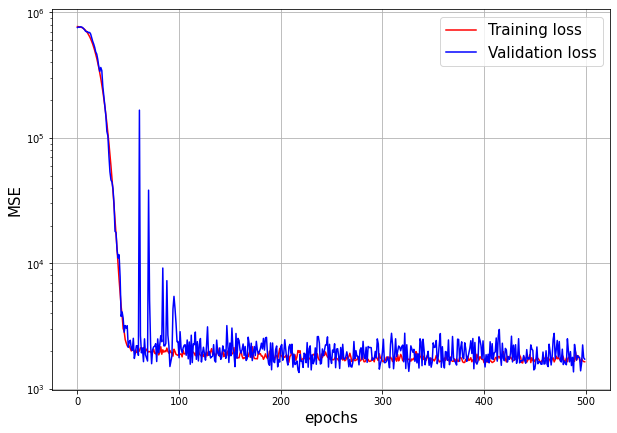

In [1007]:
plt.figure(figsize = (10,7))
epochs = len(train_loss)
plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
plt.plot(range(epochs),valid_loss,'-b',label = 'Validation loss')
plt.yscale('log')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('epochs', fontsize=15)
plt.ylabel('MSE', fontsize=15)
# plt.title(f'Loss curve (2ks {len(dataset.guage_space)}sensor)', fontsize = 20)}

In [1031]:
model.load_state_dict(torch.load('./Models/fnn.pth',
                                 map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()

model.eval()

net(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=400, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=900, bias=True)
  )
)

In [1036]:
error_num = 0; error_den = 0
for x,y in validation_loader:
    if torch.cuda.is_available():
        input, output = x.cuda(), y.cuda()
    error = output - model(input.float())
    error_num += torch.linalg.norm(error.flatten()).item()**2
    error_den += torch.linalg.norm(y.flatten()).item()**2
norm_error = error_num**0.5 / error_den**0.5
print(norm_error)

0.0262278651413176


In [1037]:
##NME
for i, (x,y) in enumerate(validation_loader):
  if torch.cuda.is_available():
      input, output = x.cuda(), y.cuda()
  if i == 0:
    output_stack = output
    pred_stack = model(input.float())
  else:
    output_stack = torch.cat([output_stack,output])
    pred_stack = torch.cat([pred_stack,model(input.float())])
  # print(output_stack.shape, pred_stack.shape)
error = torch.linalg.norm(output_stack - pred_stack)/torch.linalg.norm(output_stack)
print(f'Normalized Error: {error}')

Normalized Error: 0.04403629001847508


In [1038]:
##NFE
target = output_stack - pred_stack.mean(dim =0)
pred = pred_stack - pred_stack.mean(dim =0)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.8158985058652006


In [1039]:
r2_score(output_stack.flatten().detach().numpy(), pred_stack.flatten().detach().numpy())

0.9978126304417113

In [1050]:
#test with last input from input.txt (row 197)
model.eval()
x_test = torch.tensor([[0.345863,0.037831,0.074332,0.318219,0.061714,0.161887,4.7e-05,0.000106,290634.0,1684.0]])#0.294903, 0.098913, 0.061895, 0.396953, 0.039459, 0.107669, 0.000127, 0.000081, 381430.000000, 2804.000000])
pred_test = model(x_test)
y_test = torch.from_numpy(np.loadtxt('/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation/Out_files/out4.txt', delimiter= ';')[:ntimesteps, 1:-2])

In [1051]:
torch.sum(torch.square(y_test - pred_test))/torch.sum(torch.square(y_test))

tensor(0.0008, dtype=torch.float64, grad_fn=<DivBackward0>)

In [1052]:
r2_score(y_test.flatten().detach().numpy(), pred_test.flatten().detach().numpy())

0.9991472845119111

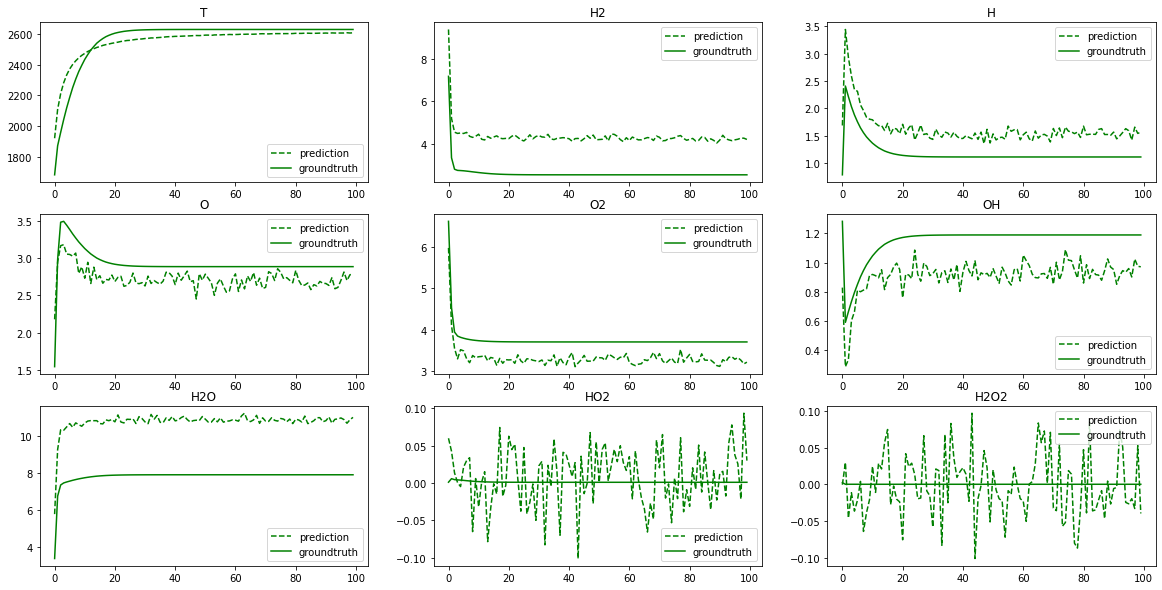

In [1053]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test[0,:,i]
    A_true = y_test[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

In [1044]:
#line 100 in input
x_test0 = torch.tensor([[0.532065,0.126334,0.106878,0.106594,0.034237,0.093657,0.000156,8e-05, 428284, 1618]])
pred_test0 = model(x_test0)
y_test0 = torch.from_numpy(np.loadtxt('Out_files/out99.txt', delimiter= ';')[:ntimesteps, 1:-2])

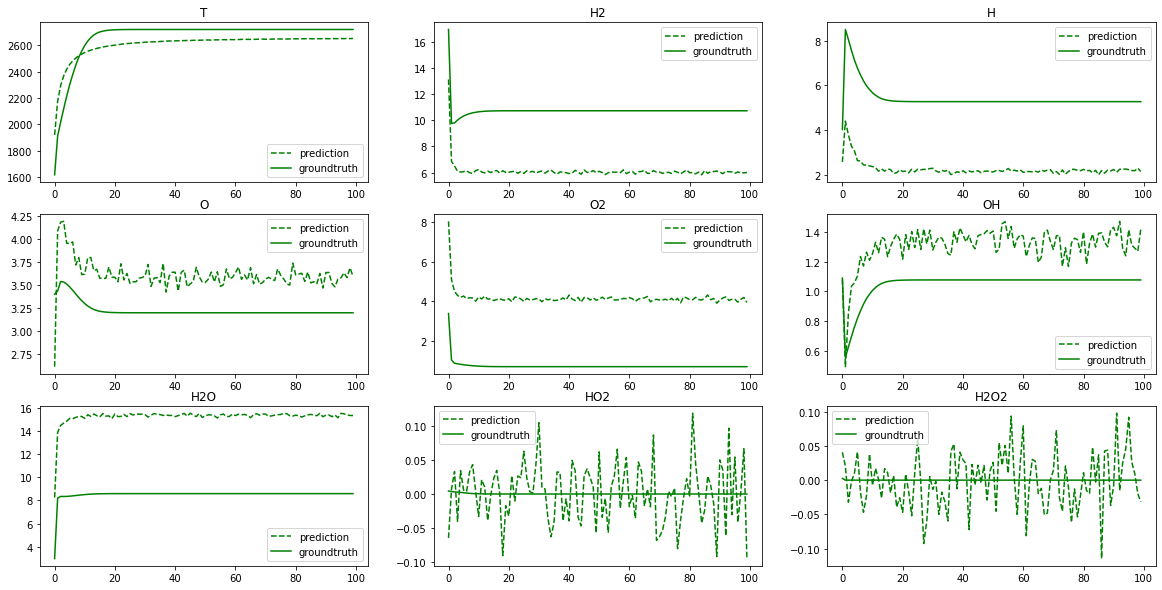

In [1045]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test0[0,:,i]
    A_true = y_test0[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

In [1046]:
#test with last input from input.txt (row 197)
x_test1 = torch.tensor([[0.294903, 0.098913, 0.061895, 0.396953, 0.039459, 0.107669, 0.000127, 0.000081, 381430.000000, 2804.000000]])
model.eval()
pred_test1 = model(x_test1)
y_test1 = torch.from_numpy(np.loadtxt('Out_files/out196.txt', delimiter= ';')[:ntimesteps, 1:-2])

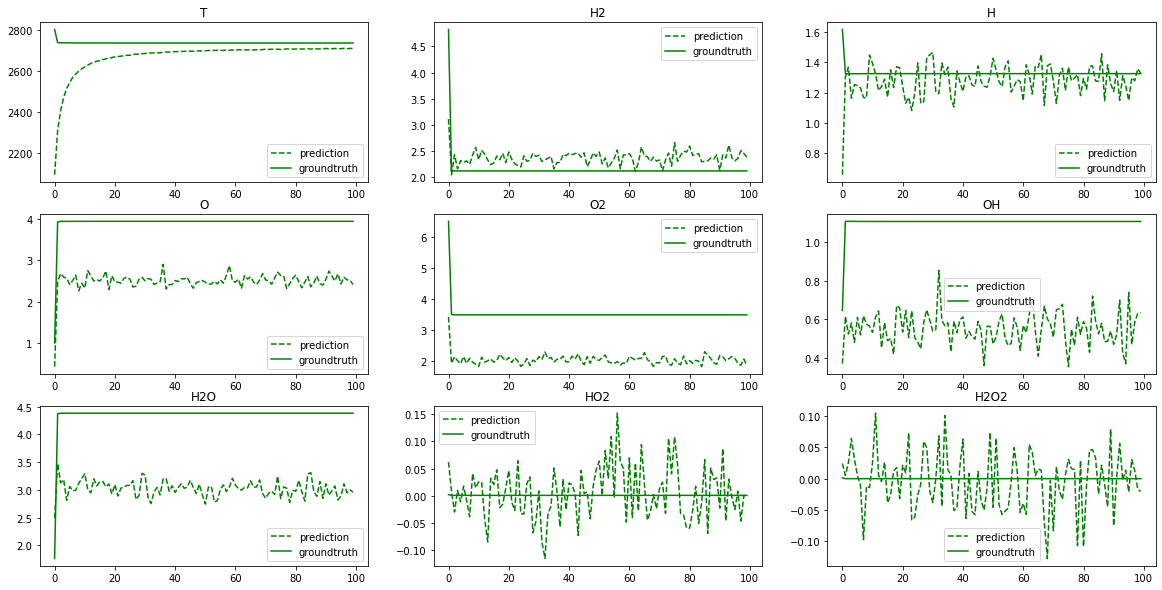

In [1047]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test1[0,:,i]
    A_true = y_test1[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--g', label = 'prediction')
    ax[a,b].plot(A_true.detach().numpy(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# plt.legend()
plt.show()

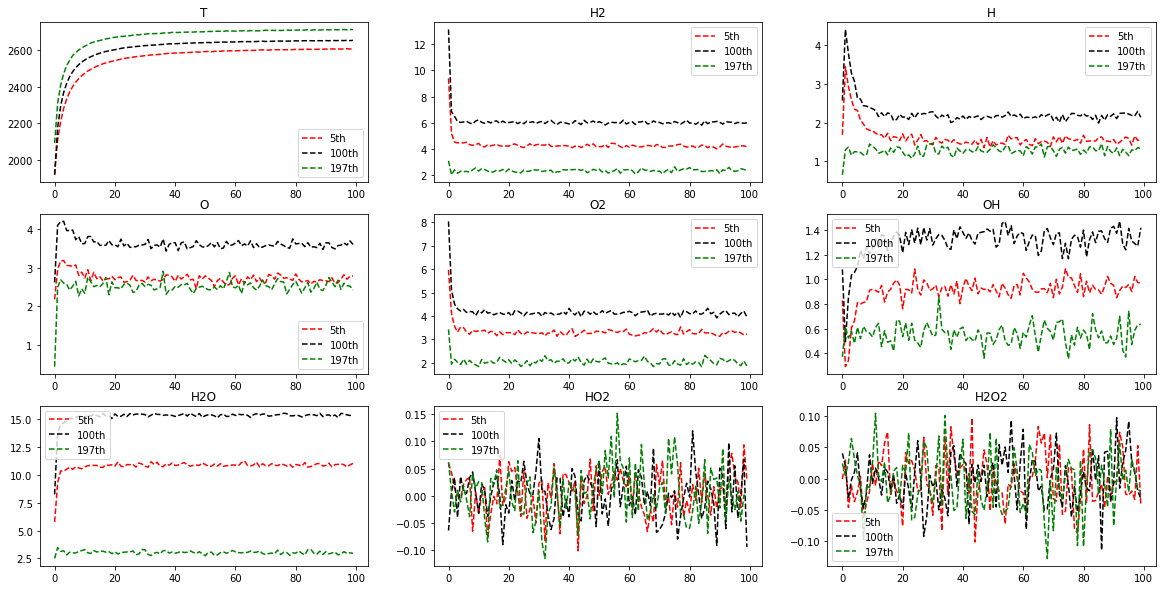

In [1048]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = pred_test[0,:,i]
    B = pred_test0[0,:,i]
    C = pred_test1[0,:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--r', label = '5th')
    ax[a,b].plot(B.detach().numpy(), '--k', label = '100th')
    ax[a,b].plot(C.detach().numpy(), '--g', label = '197th')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# fig.title('Predictions')
plt.show()

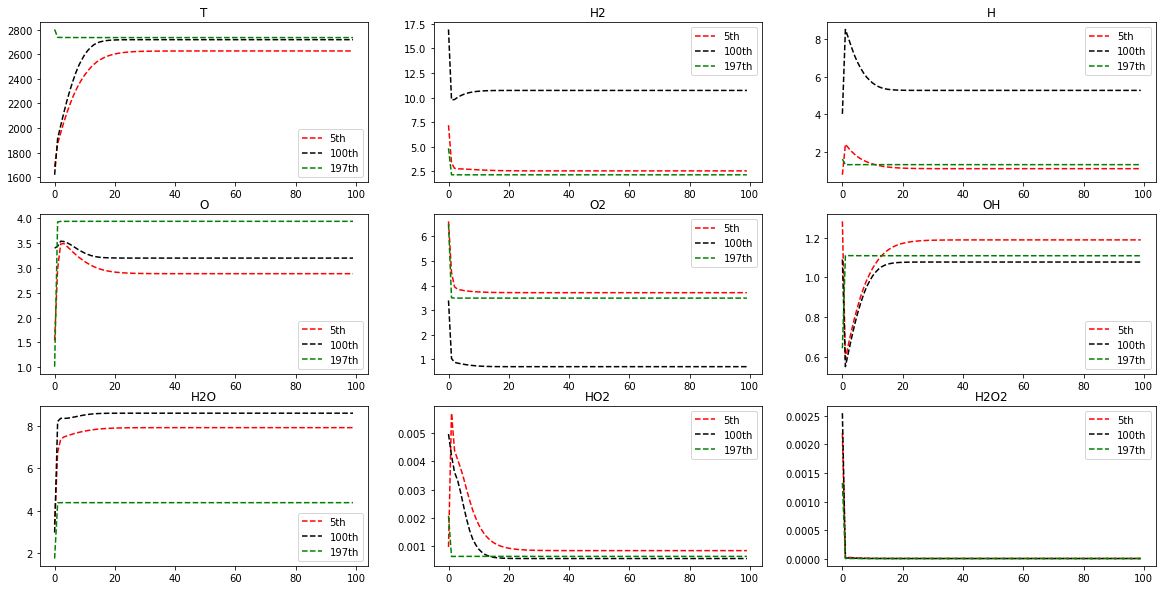

In [1049]:
fig, ax = plt.subplots(3,3, figsize = (20,10))
labels = ['T', 'H2',	'H', 'O', 'O2',	'OH',	'H2O',	'HO2',	'H2O2']
for i in range(9):
    a,b = i//3, i%3
    A = y_test[:,i]
    B = y_test0[:,i]
    C = y_test1[:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().numpy(), '--r', label = '5th')
    ax[a,b].plot(B.detach().numpy(), '--k', label = '100th')
    ax[a,b].plot(C.detach().numpy(), '--g', label = '197th')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
# fig.title('Predictions')
plt.show()

In [944]:
for i in range(3):
    m = model.layers[3*i].weight
    b = model.layers[3*i].bias
    print(f'====={3*i}======')
    print(m.mean().detach(), m.std().detach())
    print(b.mean().detach(), b.std().detach())

=====0======
tensor(0.0564) tensor(0.5724)
tensor(0.0147) tensor(0.1512)
=====3======
tensor(-0.0032) tensor(0.2153)
tensor(0.0298) tensor(0.1650)
=====6======
tensor(-0.0047) tensor(0.0848)
tensor(0.3122) tensor(0.2026)


In [529]:
y_test[4,]

tensor([2.7205e+00, 1.8806e+00, 3.4438e+00, 3.8198e+00, 7.9547e-01, 7.5150e+00,
        3.7687e-03, 1.5617e-05], dtype=torch.float64)

In [228]:
A

tensor([[1906.7864, 2241.5005, 2369.2798, 2448.4771, 2499.6350, 2528.8445,
         2541.1162, 2563.6965, 2573.1760, 2565.0425, 2584.6941, 2575.4705,
         2580.0020, 2584.3088, 2597.2722, 2599.5920, 2594.3867, 2597.4456,
         2599.5007, 2601.6626, 2603.7278, 2608.1594, 2609.2202, 2608.9348,
         2610.3811, 2611.5002, 2612.7886, 2613.7515, 2614.5532, 2616.0764,
         2616.9585, 2616.7957, 2617.4631, 2619.6982, 2620.4956, 2619.4236,
         2622.0005, 2622.7825, 2623.4954, 2621.6819, 2624.6724, 2622.7312,
         2623.1548, 2626.4128, 2625.1619, 2627.4705, 2628.0007, 2625.4243,
         2625.9709, 2626.1880, 2626.9294, 2626.9294, 2630.6655, 2627.7676,
         2631.7092, 2631.8899, 2632.2178, 2632.5156, 2632.8757, 2633.2319,
         2633.5786, 2633.8838, 2634.2378, 2630.6648, 2630.9602, 2635.1472,
         2635.5718, 2635.6909, 2635.9548, 2632.3521, 2636.3359, 2632.5796,
         2636.7942, 2637.1099, 2637.1838, 2633.1060, 2637.5439, 2637.7278,
         2633.5251, 2633.